### Lane Line Detection

This projects consists of a software pipeline written in Python to detect lane lines in images and then effectively a video stream. The ability to effectively detect lane lines on a road is a important step in building software to power a Self-Driving car, this project demonstrates a small scale version of that feature

In [68]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob # Library to read in files with a consistent filename 
%matplotlib inline

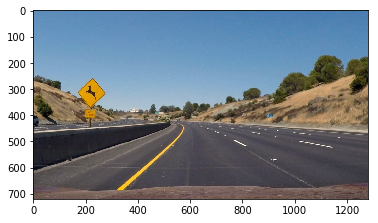

In [84]:
# Read in a test image
test_img = mpimg.imread('./test_images/test2.jpg')
plt.imshow(test_img)

# Camera Calibration

In a typical self driving car the eyes of the driver is replaced by cameras, cameras however don't record perfect videos and in most cases the video is strectched/distorted in some way which can affect out software from accurately observing the environment. To combat this we would like to apply techniques to undistort the image.

First the camera will be calculated using calibration images and then the resulting camera matrix and distortion coefficients will be used to undistort the image. 

## Calculate points for calibrating camera

Calculate the object points and image points used for calibrating the camera

In [62]:
# %matplotlib qt

cal_images = glob.glob('camera_cal/calibration*.jpg')

# Prepare object points like (0,0,0), (1, 0, 0), (2, 0, 0), ...., (8, 5, 0)
objp = np.zeros((6*9, 3), np.float32) # Initialize all to 0

# Use numpy's mgrid function to generate points https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mgrid.html
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates only

def load_points(images):
    # Arrays to store object points and image points from all the images

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image space
    for fname in images:
        # Read in image
        img = mpimg.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
#             cv2.drawChessboardCorners(img, (9,6), corners, ret)
#             cv2.imshow('img', img)
#             cv2.waitKey(500)
    return objpoints, imgpoints
        
objpoints, imgpoints = load_points(cal_images)

## Function to Undistort image 

A function to undistort the image given the object points and image points calcaulated

In [63]:
def undistort_image(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    
    # Calibrate the camera 
    ret, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = \
        cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Undistort the image
    undistorted_img = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
    
    return undistorted_img

undistorted = undistort_image(test_img, objpoints, imgpoints)

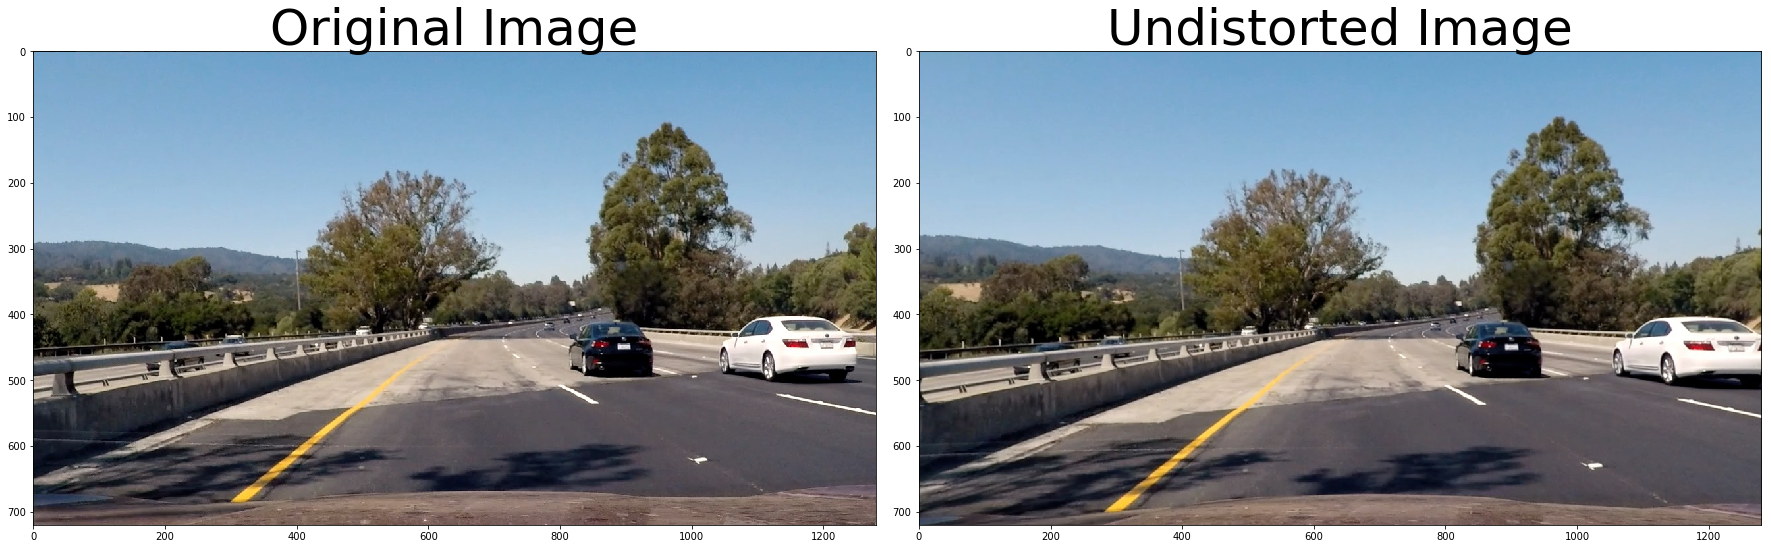

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

Next we would like to apply a perspective transform to change the way we the application views the video. The goal is to properly detect the curvature of lane lines in the road and this is easier for the application to do if it were to have a top down view of the road. As such we will use a perspective transform to warp the image from its current viewpoint to a top down view.

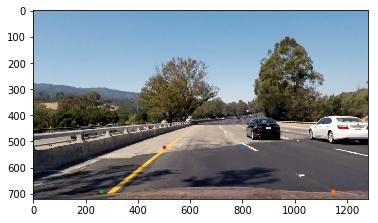

In [65]:
%matplotlib inline

plt.imshow(undistorted)
plt.plot(800, 520, '.') # Top right
plt.plot(1145, 690, '.') # Bottom right
plt.plot(260, 690, '.') # Bottom left
plt.plot(500, 520, '.') # Top left


In [66]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [[800, 520],
         [1145, 690],
         [260, 690],
         [500, 520]])
    
    dst = np.float32(
        [[1000, 200],
         [1000, 650],
         [400, 650],
         [400, 200]])
    
    M = cv2.getPerspectiveTransform(src, dst) # mapping as perspective matrix
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped_img = warp(undistorted)

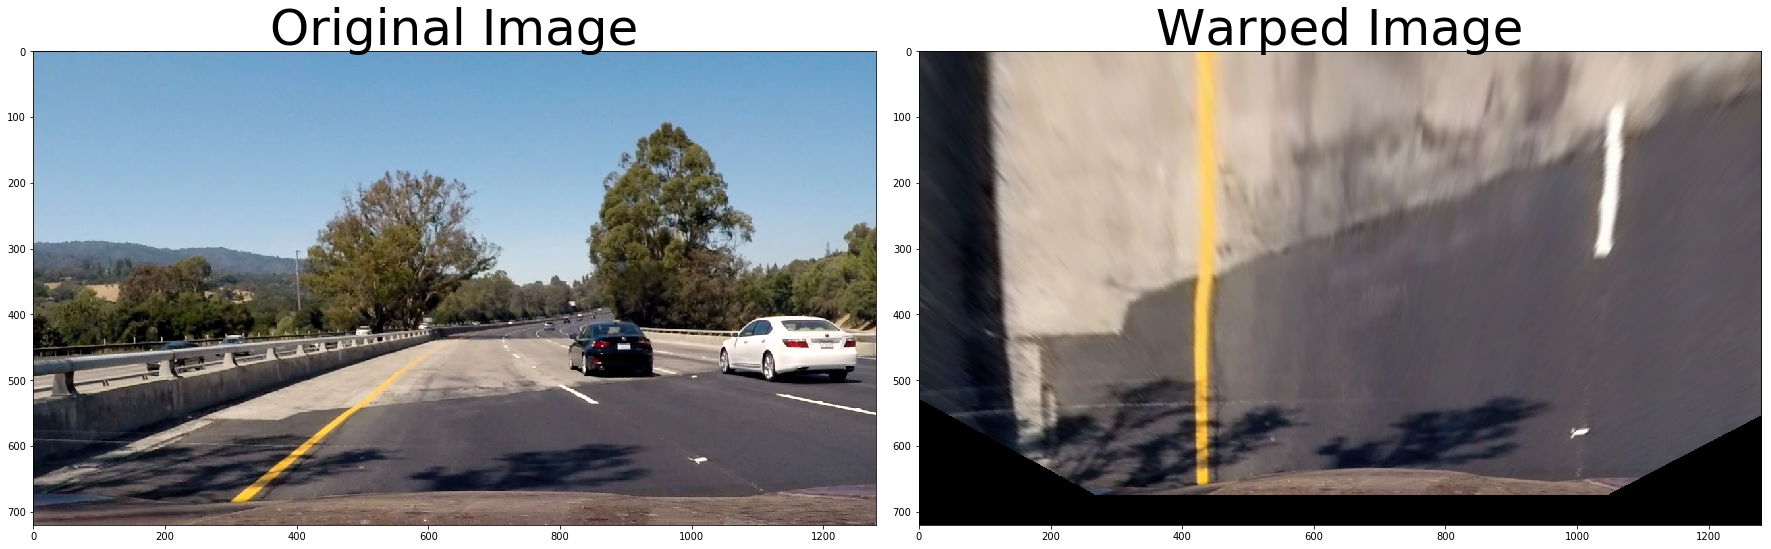

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Gradient thresholding

In order to focus on important information(lane lines) calculating the gradient of what the camera sees and bounding that within a threshold is definately a useful technique. Below Various forms of gradient thresholding functions are implemented and then combined in the effort to properly identify lane lines

In [96]:
ksize = 15

In [104]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

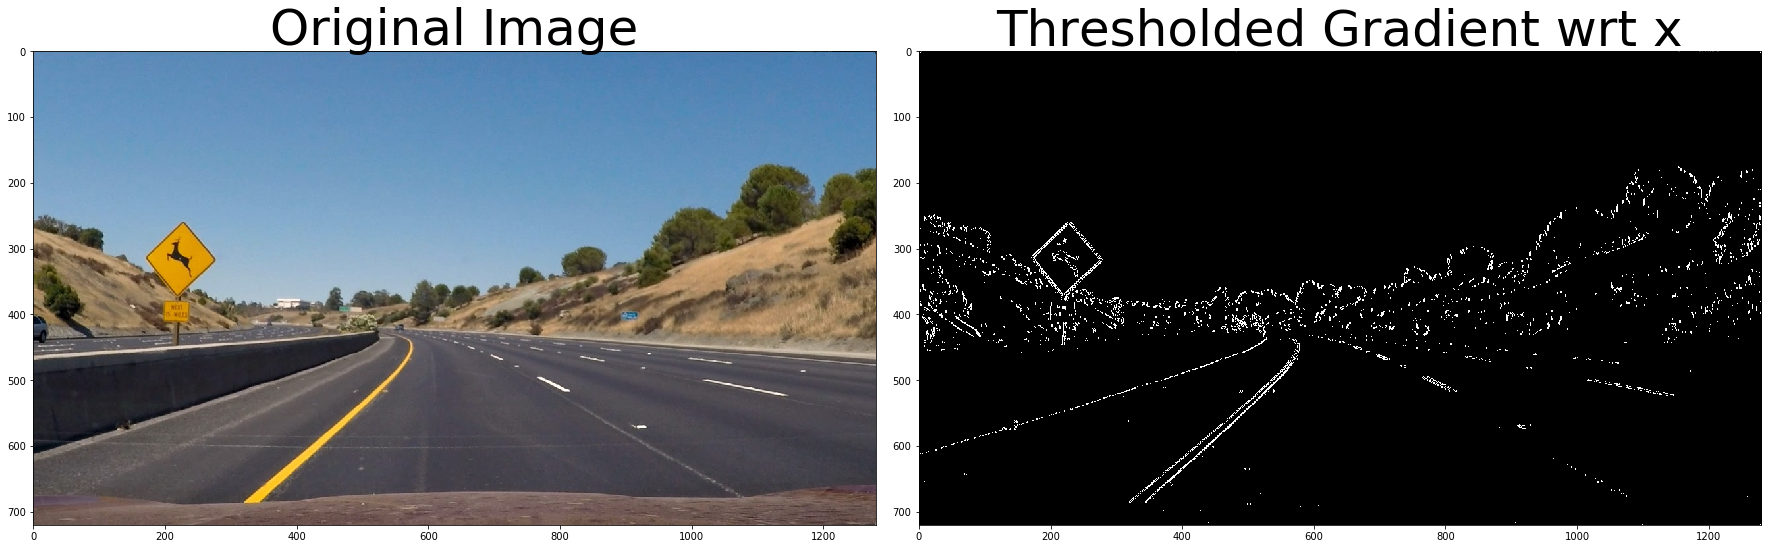

In [127]:
min_thresh_gradx, max_thresh_gradx = 40, 100

gradx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=ksize, thresh_min=min_thresh_gradx, thresh_max=max_thresh_gradx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Gradient wrt x', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

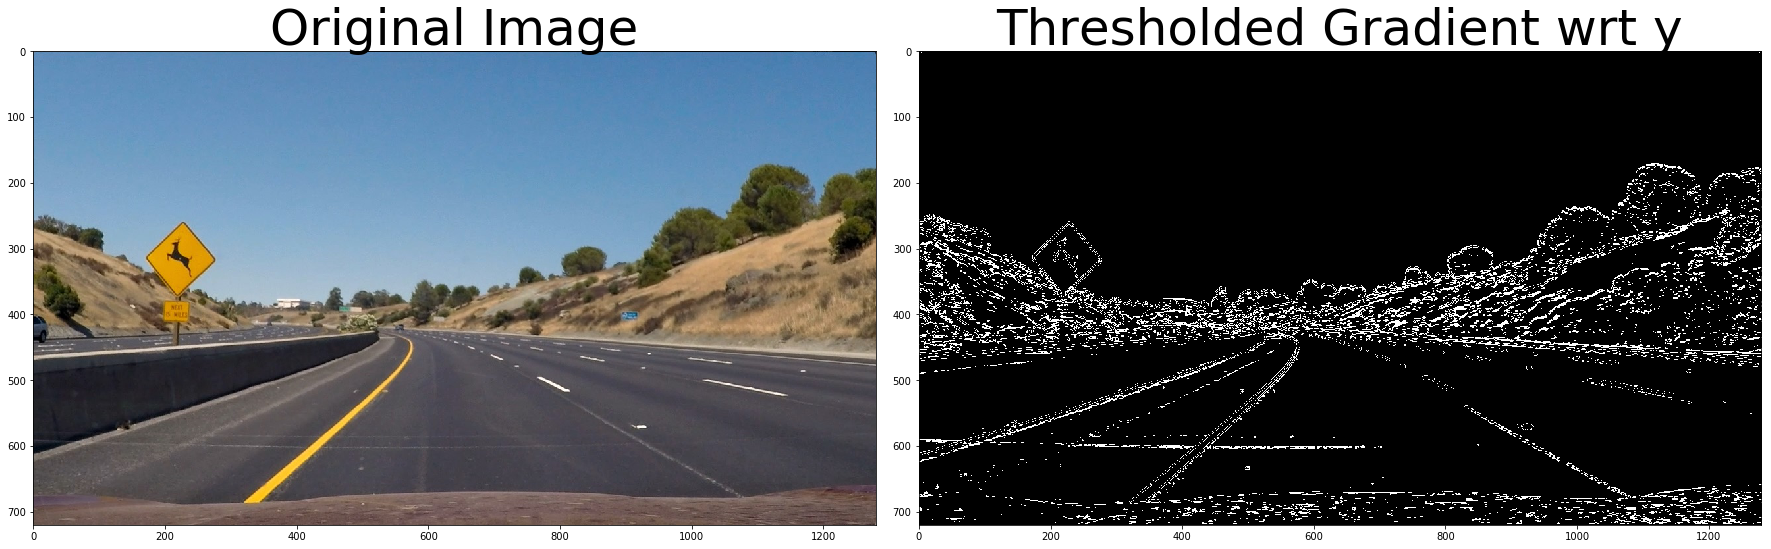

In [131]:
min_thresh_grady, max_thresh_grady = 20, 50
grady = abs_sobel_thresh(test_img, orient='y', sobel_kernel=ksize, thresh_min=min_thresh_grady, thresh_max=max_thresh_grady)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Thresholded Gradient wrt y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [132]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

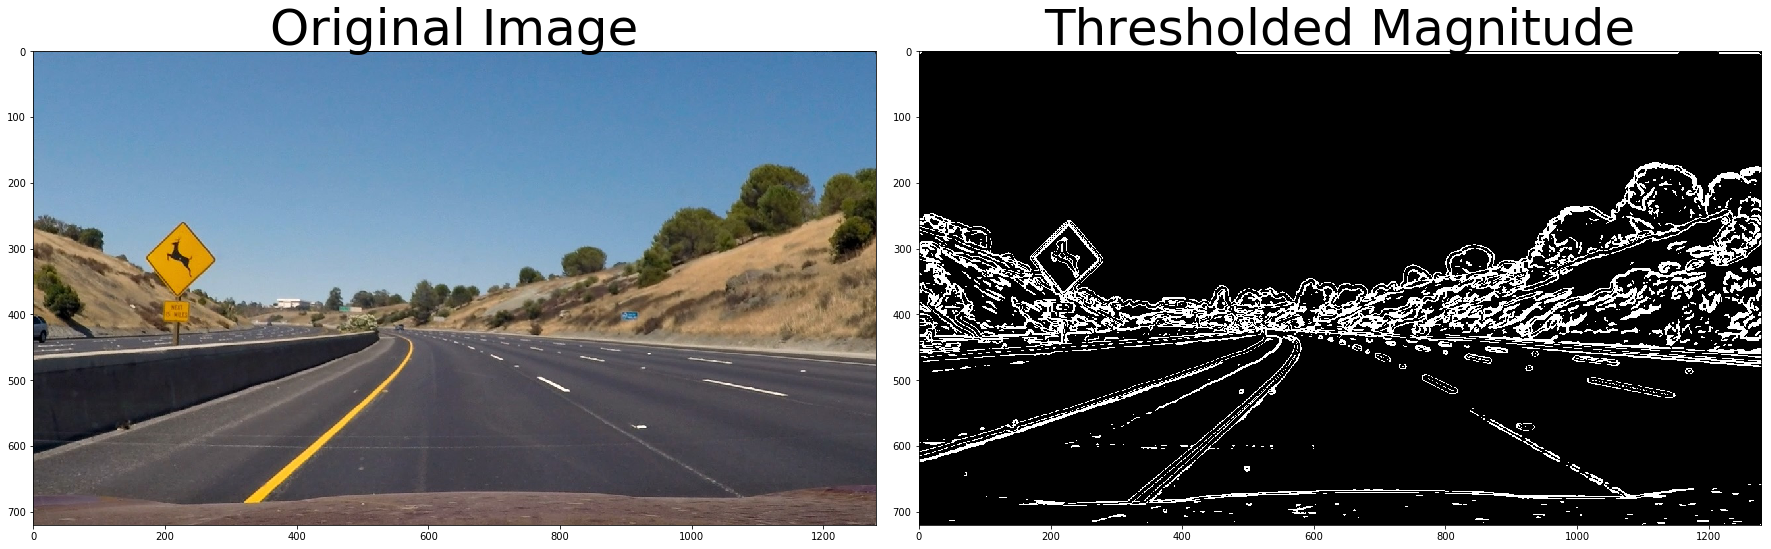

In [136]:
min_thresh_magnitude, max_thresh_magnitude = 30, 80
mag_binary = mag_thresh(test_img, sobel_kernel=ksize, mag_thresh=(min_thresh_magnitude, max_thresh_magnitude))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [137]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


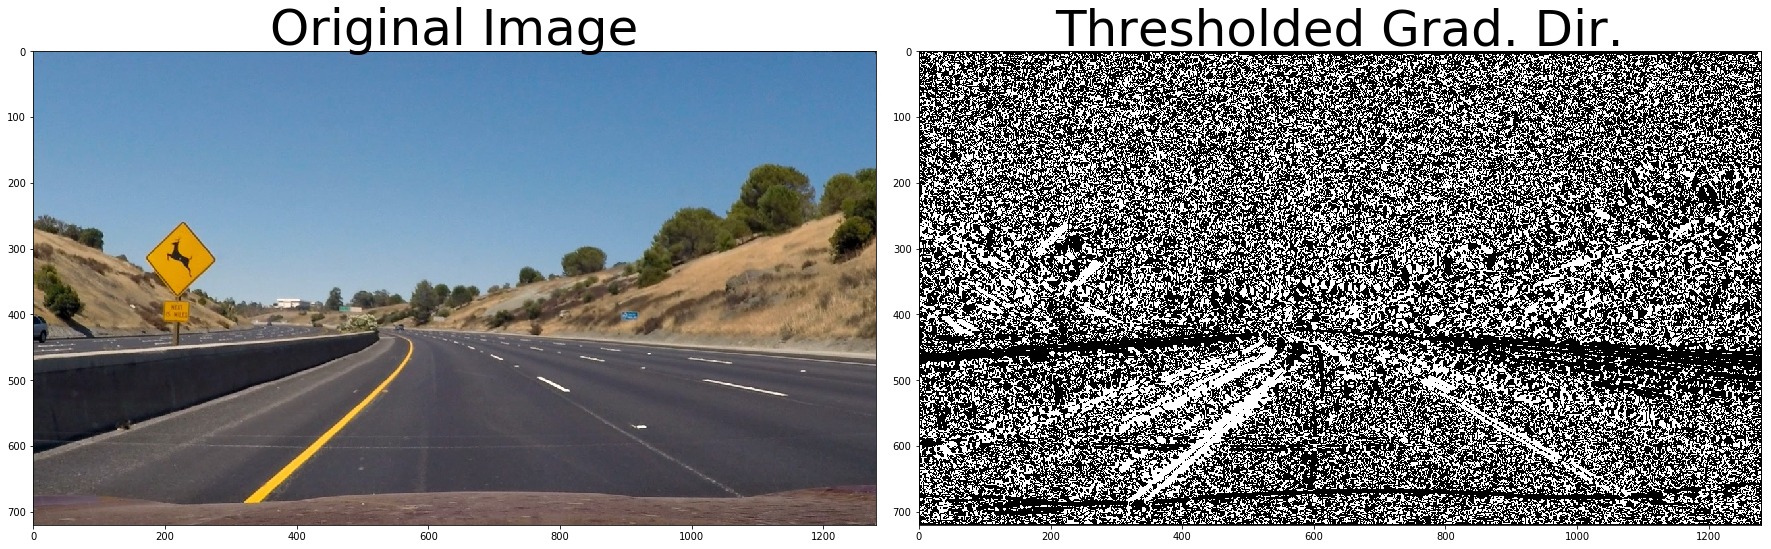

In [138]:
min_thresh_dir, max_thresh_dir = 0.7, 1.3
dir_binary = dir_threshold(test_img, sobel_kernel=ksize, thresh=(min_thresh_dir, max_thresh_dir))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

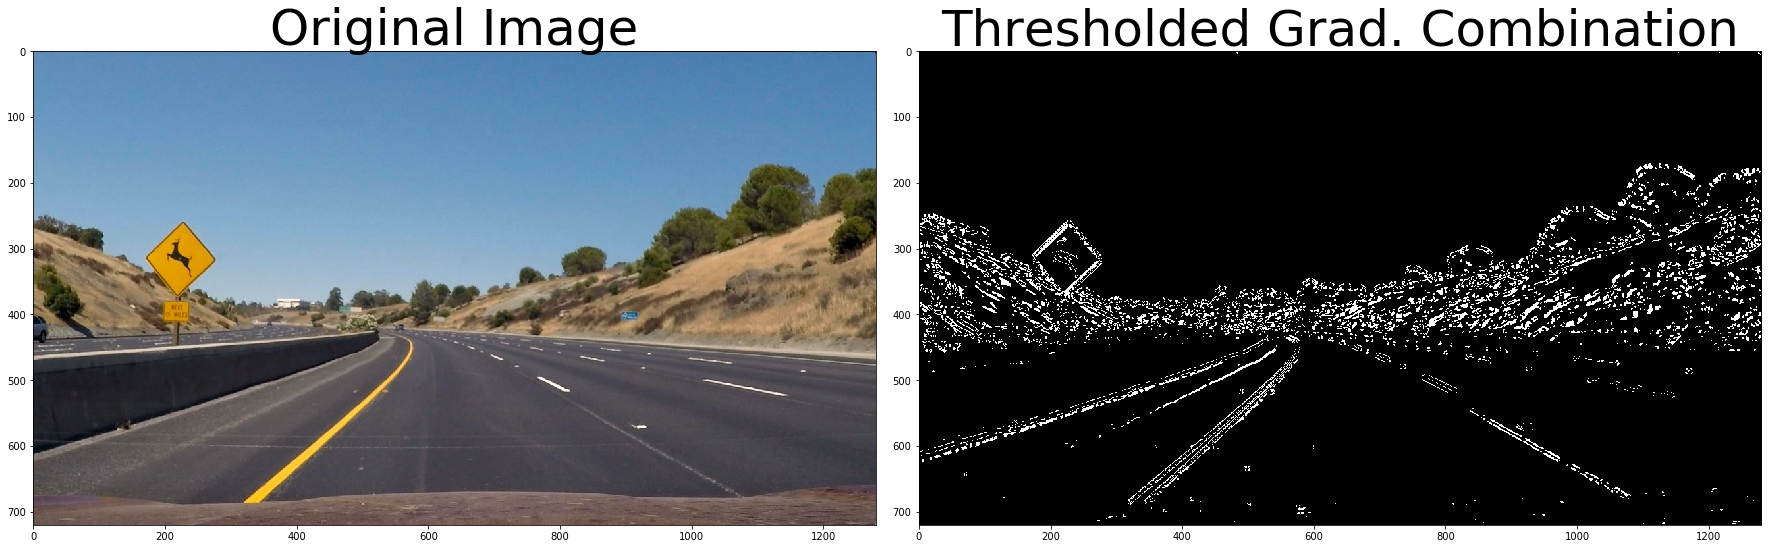

In [193]:
combined = np.zeros_like(dir_binary)
# combined[(((gradx == 1) & (grady == 1)) | (mag_binary == 1)) & (dir_binary == 1)] = 1
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Combination', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now to apply this to the warped image

In [ ]:
def apply_gradient_threshold(img):
    gradx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=ksize, thresh_min=min_thresh_gradx, thresh_max=max_thresh_gradx)
    grady = abs_sobel_thresh(test_img, orient='y', sobel_kernel=ksize, thresh_min=min_thresh_grady, thresh_max=max_thresh_grady)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(min_thresh_magnitude, max_thresh_magnitude))

# Color Thresholding

In [147]:
# Convert the image to grayscale and apply a threshold that identfies lines
thresh = (180, 255)
gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

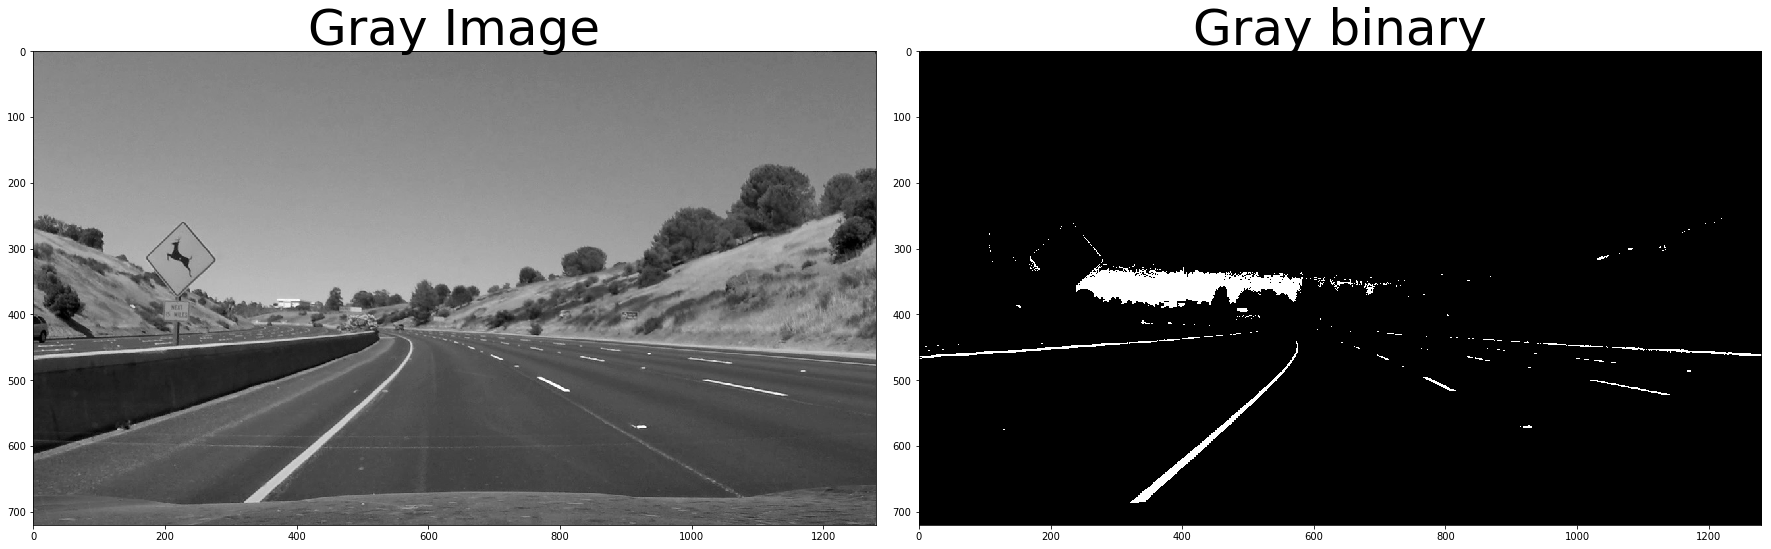

In [153]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Gray binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

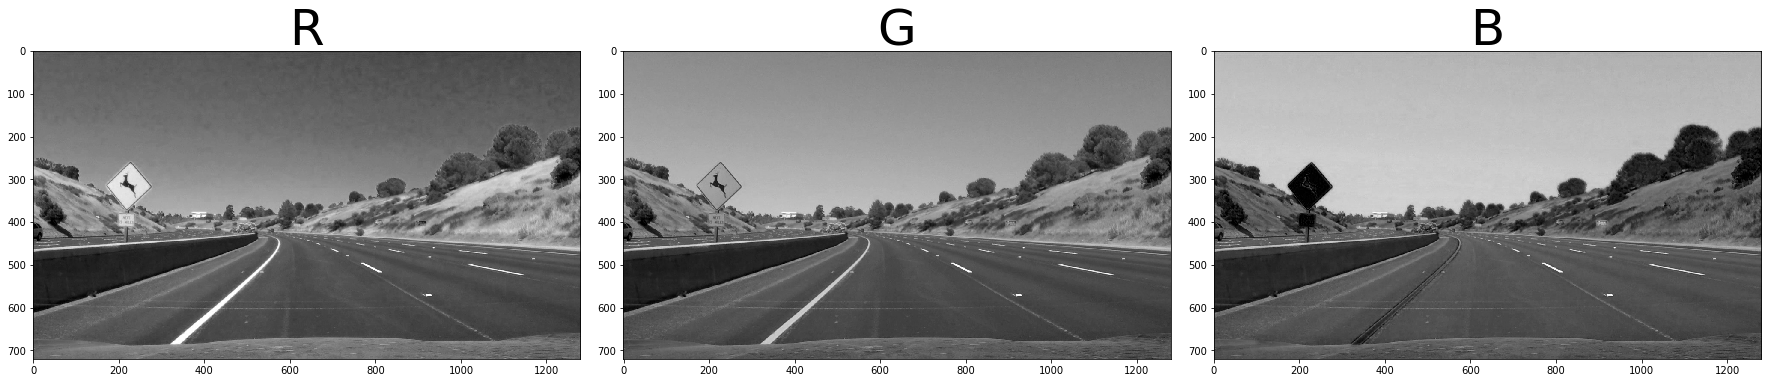

In [155]:
# Individual RGB values
R = test_img[:,:,0]
G = test_img[:,:,1]
B = test_img[:,:,2]

In [ ]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(G, cmap='gray')
ax2.set_title('G', fontsize=50)
ax3.imshow(B, cmap='gray')
ax3.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [158]:
# Apply a threshold to the individual channel
thresh = (200, 255)
binaryR = np.zeros_like(R)
binaryR[(R > thresh[0]) & (R <= thresh[1])] = 1

binaryG = np.zeros_like(G)
binaryG[(G > thresh[0]) & (G <= thresh[1])] = 1

binaryB = np.zeros_like(R)
binaryB[(B > thresh[0]) & (B <= thresh[1])] = 1

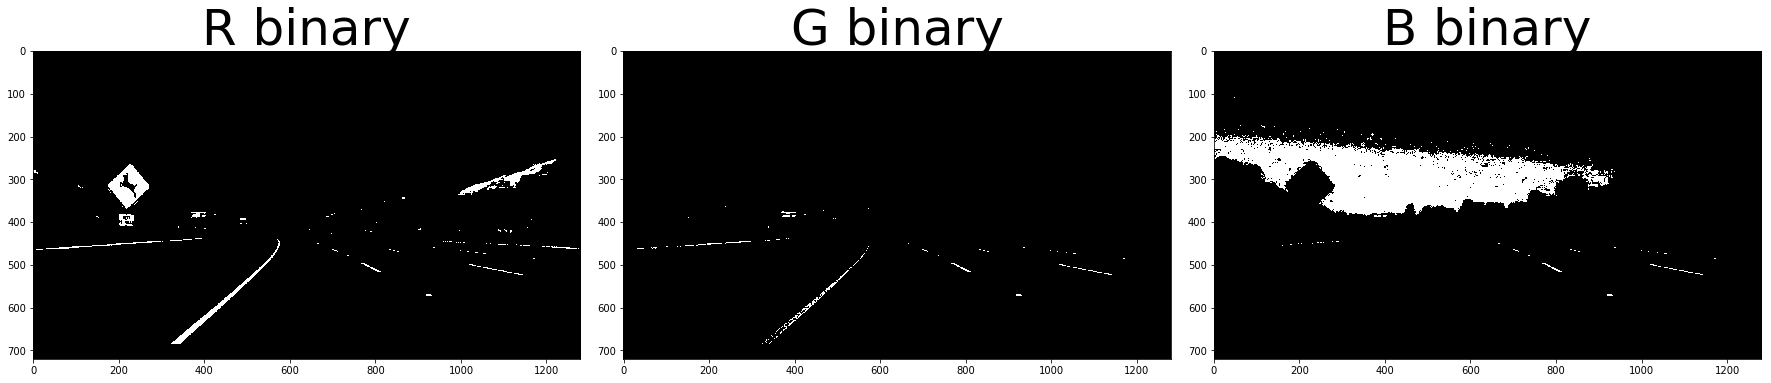

In [159]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binaryR, cmap='gray')
ax1.set_title('R binary', fontsize=50)
ax2.imshow(binaryG, cmap='gray')
ax2.set_title('G binary', fontsize=50)
ax3.imshow(binaryB, cmap='gray')
ax3.set_title('B binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### HLS Color Space

R channel seems to be doing a good job but I will be considering a separate color space that might lead to better results. 

In [188]:
# Individual HLS values
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

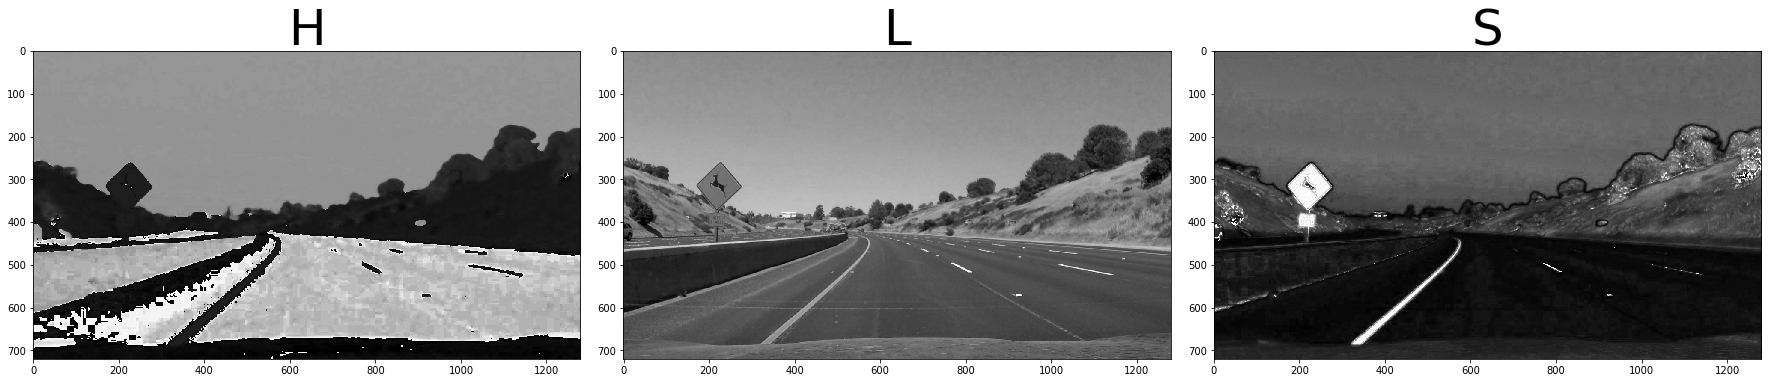

In [189]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S, cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [190]:
# Apply a threshold to each individual channel
threshH = (15, 100)
binaryH = np.zeros_like(H)
binaryH[(H > threshH[0]) & (H <= threshH[1])] = 1

threshL = (140, 215)
binaryL = np.zeros_like(L)
binaryL[(L > threshL[0]) & (L <= threshL[1])] = 1

threshS = (90, 255)
binaryS = np.zeros_like(S)
binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1

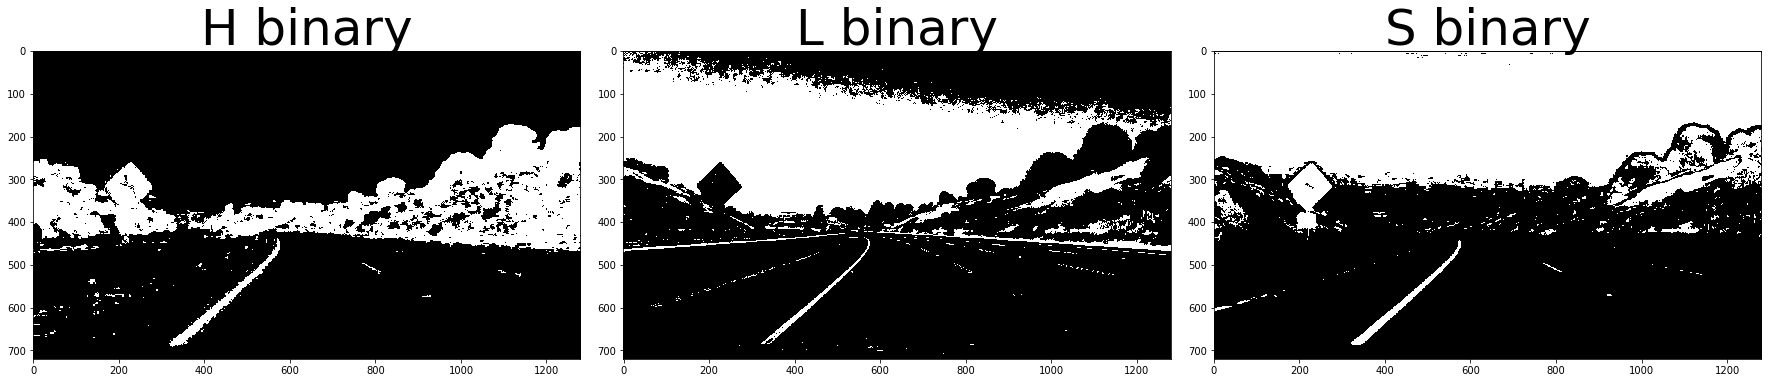

In [191]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binaryH, cmap='gray')
ax1.set_title('H binary', fontsize=50)
ax2.imshow(binaryL, cmap='gray')
ax2.set_title('L binary', fontsize=50)
ax3.imshow(binaryS, cmap='gray')
ax3.set_title('S binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

It seems the S channel is performing the best but not by much, it's a bit cleaner so will stick with HLS space and observe results. Let's combine the S channel threshold with the combined Gradient threshold see the result

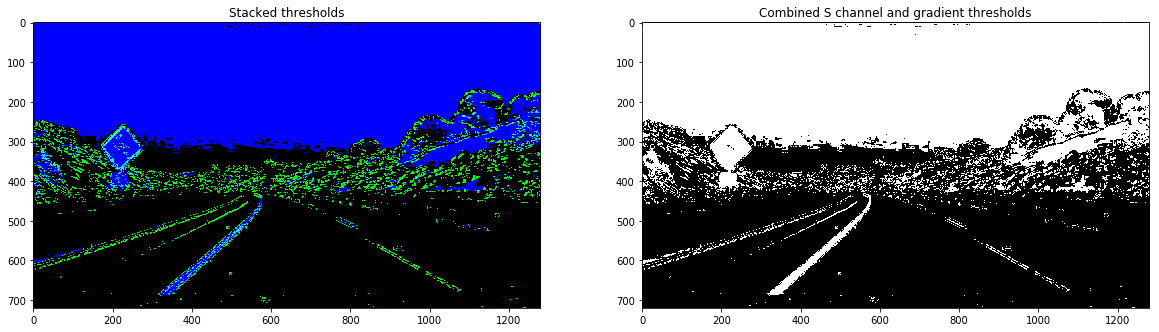

In [202]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(combined), combined, binaryS)).astype(np.uint8) *255

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(binaryS == 1) | (combined == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')